In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.morphology import distance_transform_edt 

#### Gradient Ascent 
\begin{align}
\mathbf{r}_{i+1}&=\mathbf{r}_i+\eta\Delta \mathbf{r} \\
\Delta\mathbf{r} &\sim -\frac{\nabla \mathbf{f}}{\|\nabla \mathbf{f}\|}
\end{align}
where $\mathbf{f}$ the potential field, $\nabla$ the gradient, $i$ the iteration of the for-loop, $\eta$ the rate of change constant and $\mathbf{r}$ the position.

In [2]:
def mesh(X,Y,Z):
    ax = plt.gca()
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    # ax.contour3D(x, y, repulmap, 50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(70,-110)

In [3]:
def round2(n):
    return np.floor(n+ 0.5).astype(int)

In [4]:
class PotentialFieldPathDemo:
    def __init__(self):
        self.nrows = 400
        self.ncols = 600
        self.d0 = 2
        self.nu = 800
        self.start = np.array([50,350])
        self.goal = np.array([400,50])
        self.xi = 1/700
        self.x,self.y=np.meshgrid(np.linspace(1,self.ncols,self.ncols),
                       np.linspace(1,self.nrows,self.nrows))
        self.maxIter = 1000
    def generateObstacle(self):
        obstacle = False*np.ones((self.nrows,self.ncols))
        obstacle[299:,99:249] = True
        obstacle[149:199, 399:499] = True
        t = ((self.x-200)**2+(self.y-50)**2) < 50**2
        obstacle[t] = True
        t = ((self.x-400)**2+(self.y-300)**2)< 100**2
        obstacle[t] = True
        d = distance_transform_edt(1-obstacle)
        d2 = d/100 + 1
        repulsive=self.nu*((1/d2-1/self.d0)**2)
        repulsive[d2>self.d0] = 0
        return obstacle,repulsive,self.x,self.y
    def generateAttractive(self):
        attractive=self.xi*((self.x-self.goal[0])**2+
                            (self.y-self.goal[1])**2)
        return attractive,self.x,self.y
    def GradientBasedPlanner(self,f):
        gy,gx = np.gradient(-f)
        route = self.start.reshape(-1,2).astype(float); 
        rate = 1
        current = route[0,:]
        
        G = np.sqrt(gx**2+gy**2); gx /= G; gy /= G
        for i in range(self.maxIter):
            tmpx = round2(current[1])
            tmpy = round2(current[0])
            current+=rate*np.array([gx[tmpx,tmpy],gy[tmpx,tmpy]])
            if np.sum(current<=0):
                break
            elif np.prod(round2(current)==self.goal):
                print('yes')
                break
            route = np.concatenate((route,
                            np.array(current).reshape(-1,2)))
        route = np.concatenate((route,
                            np.array(current).reshape(-1,2)))

        return route

In [5]:
demo = PotentialFieldPathDemo()
obsmap,repulmap,x,y = demo.generateObstacle()
attmap,_,_ = demo.generateAttractive()
f = repulmap+attmap
route = demo.GradientBasedPlanner(f)

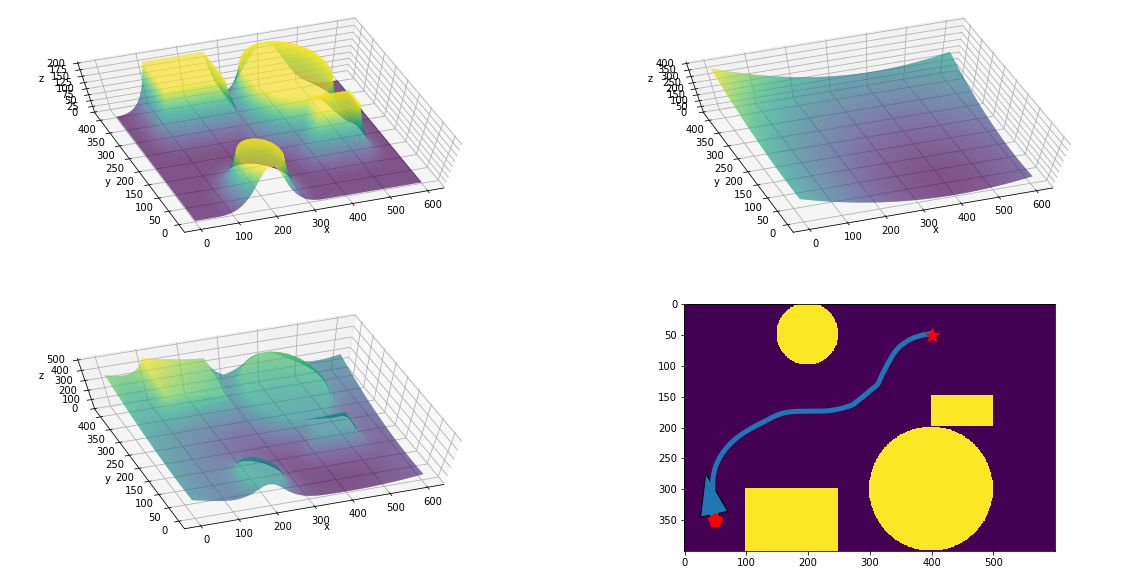

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(221,projection='3d'); mesh(x,y,repulmap)
plt.subplot(222,projection='3d'); mesh(x,y,attmap)
plt.subplot(223,projection='3d'); mesh(x,y,f)
plt.subplot(224); 
plt.imshow(obsmap)
plt.plot(route[:,0],route[:,1],'-',linewidth=5)
dxdy = route[10,:] - route[0,:]
plt.arrow(route[0,0],route[0,1],dxdy[0],dxdy[1],width=15)
plt.plot(demo.start[0],demo.start[1],
             'rp',markersize=15)
plt.plot(demo.goal[0],demo.goal[1],
            'r*',markersize=15)    